In [1]:
import numpy as np
from astropy.io.votable import parse
import pandas as pd

%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [2]:
# This notebook is for managing the metadata for the Lori Allen Data Set

# Initialize variable
neo_metadata_df = None

# Set the range of nights to ingest into the data frame
for night_num in range(1,32):
    
    # Create the data frame
    metadata_df = pd.DataFrame()
    
    # Create a string for the give night's file name
    night_str = 'night_%i.vot' % night_num
    
    # Ingest data into a table
    votable = parse(night_str)
    table = votable.get_first_table()
    
    # Turn the table into a data array
    data = table.array
    
    # Load file names for future use
    file_names = data['archive_file'].data
    
    # visit_id's need additional parsing so take them out now
    visit_id = data['dtacqnam'].data
    
    # Create fields in the data frame with given values
    metadata_df['visit_id'] = np.array([x[-14:-8] for x in visit_id])
    metadata_df['date_obs'] = data['date_obs'].data
    metadata_df['ra'] = data['ra'].data
    metadata_df['dec'] = data['dec'].data
    metadata_df['product'] = data['prodtype'].data
    metadata_df['filename'] = file_names
    metadata_df['survey_night'] = night_num
    
    # Now add the data frame for a given night to the total data frame
    if neo_metadata_df is None:
        neo_metadata_df = metadata_df
    else:
        neo_metadata_df = pd.concat([neo_metadata_df, metadata_df])

# Only keep image data
neo_metadata_df = neo_metadata_df[neo_metadata_df['product'] == b'image']
neo_metadata_df = neo_metadata_df.reset_index(drop=True)

<IPython.core.display.Javascript object>


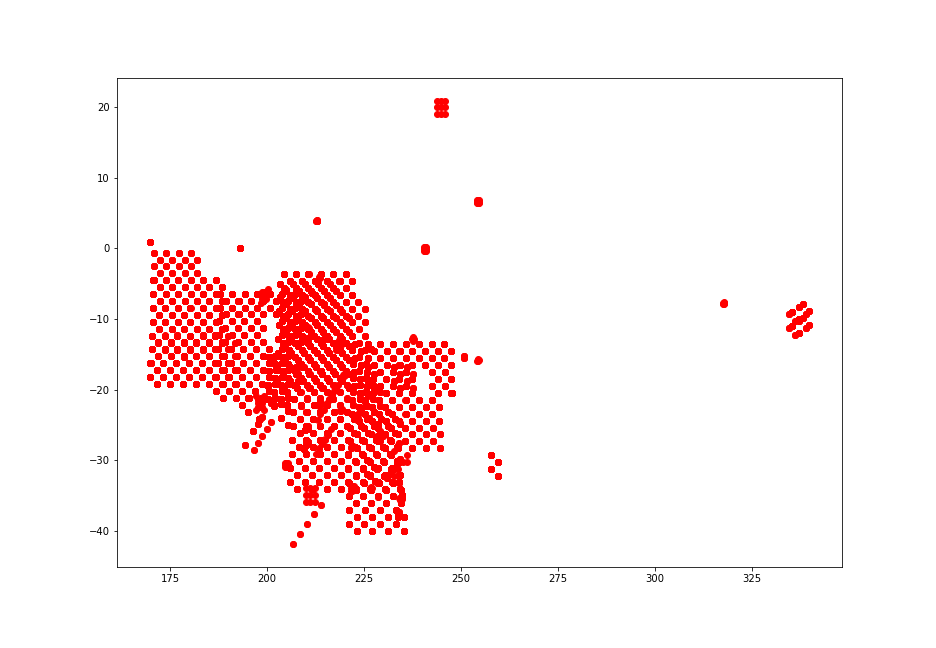

In [3]:
arcsec2degree = 0.000277778

pixscale = 0.2637 #arcsec/px
height   = 2048 * pixscale * arcsec2degree
width    = 4096 * pixscale * arcsec2degree

visit_id = neo_metadata_df["visit_id"]
ra       = neo_metadata_df["ra"]
dec      = neo_metadata_df["dec"]
angle    = [0]*len(ra)

fig, ax = plt.subplots(figsize=(13, 9))

rect_patches = []
for i, r, d, a in zip(visit_id, ra, dec, angle):
    # this will likely kill the notebook
    #annot = ax.text(r-0.001, d-0.001, i, fontsize=12)
    #                 lower left corner        height  width  angle
    rect = Rectangle((r-height/2., d-width/2.), height, width, a)
    rect_patches.append(rect)
rect_patches_collection = PatchCollection(rect_patches, alpha=0.1)
ax.add_collection(rect_patches_collection)

ax.scatter(ra, dec, color="red")

plt.show()

In [4]:
# This value determines how close RA has to be in order to be considered "equal"
ra_tol = 5e-2

# Same as Ra_Tol, but for DEC
dec_tol = 5e-2

# Minimum number of visits
min_num_visits = 3

# Make a copy that we can manipulate
df_copy = neo_metadata_df

# Drop a few unnecessary columns
#df_copy = df_copy.drop(['product','filename'],axis=1)

# Set a maxinimum number of interations just in case
max_iter = neo_metadata_df.axes[0][-1]
i = 0

# Initialize an array that will hold the dataframes for the sorted fields
sorted_fields = []

# This while loop interates over a given field, groups the data, and adds it to Sorted_Fields
while (not df_copy.empty) and (i<max_iter):
    # Save the values for the current field
    current_ra  = df_copy['ra'][0]
    current_dec = df_copy['dec'][0]
    current_id  = df_copy['visit_id'][0]
    
    # Find all entries that are a part of this field.
    # Note that we have to use np.close because even within a field, RA and DEC vary somewhat
    ra_mask  = np.isclose(current_ra,df_copy['ra'], atol=ra_tol)
    dec_mask = np.isclose(current_dec,df_copy['dec'], atol=dec_tol)
    duplicate_mask = (df_copy['visit_id'] == current_id)
    
    # Save the indicies for this field
    indexes = df_copy.index[ra_mask & dec_mask]
    
    # Create a new dataframe that only includes the entries of this field
    new_field = df_copy.loc[indexes]
    new_field.sort_values(['date_obs'])
    new_field = new_field.reset_index(drop=True)
    
    # Append the new field to the overall array
    sorted_fields.append(new_field)
    df_copy = df_copy.drop(indexes)
    df_copy = df_copy.reset_index(drop=True)
    i+=1

# Clean up the output
for i,_ in enumerate(sorted_fields):
    # Convert the visit_id field to a numeric value
    sorted_fields[i]["visit_id"] = pd.to_numeric(sorted_fields[i]["visit_id"])
    
    # Find the index of duplicate visit_id values
    no_duplicates = sorted_fields[i]["visit_id"].drop_duplicates()
    
    # Drop the duplicates
    sorted_fields[i] = sorted_fields[i].loc[no_duplicates.index]
    
    # Reset indicies
    sorted_fields[i] = sorted_fields[i].reset_index(drop=True)
    
# Now sort the array based on the length of the series
sorted_fields = sorted(sorted_fields, key=len, reverse=True)

# Strip out all values that have fewer visits than Min_Num_Visits
temp_fields = []
for field in sorted_fields:
    if len(field) > min_num_visits:
        temp_fields.append(field)

sorted_fields = temp_fields

In [5]:
# Print the sorted lists of fields. The longest (by number of visits) fields will be first
_=[print(field) for field in sorted_fields]

    visit_id                    date_obs          ra        dec   product  \
0     439116  b'2015-05-20 10:12:35.083'  257.655417 -29.255417  b'image'   
1     439120  b'2015-05-20 10:17:14.409'  257.655333 -29.256250  b'image'   
2     439124  b'2015-05-20 10:23:13.327'  257.657042 -29.256778  b'image'   
3     439128  b'2015-05-20 10:29:16.399'  257.656083 -29.255667  b'image'   
4     439707  b'2015-05-21 10:02:26.888'  257.652042 -29.258389  b'image'   
5     439711  b'2015-05-21 10:07:16.391'  257.651875 -29.259500  b'image'   
6     439715  b'2015-05-21 10:11:54.434'  257.652792 -29.259333  b'image'   
7     439719  b'2015-05-21 10:16:36.741'  257.652708 -29.259056  b'image'   
8     439723  b'2015-05-21 10:22:09.298'  257.653875 -29.259528  b'image'   
9     440411  b'2015-05-22 09:57:57.005'  257.650625 -29.258944  b'image'   
10    440415  b'2015-05-22 10:02:49.875'  257.649542 -29.259583  b'image'   
11    440419  b'2015-05-22 10:07:38.801'  257.650208 -29.259806  b'image'   

    visit_id                    date_obs          ra        dec   product  \
0     303665  b'2014-04-23 03:10:44.037'  212.142500 -12.421111  b'image'   
1     303669  b'2014-04-23 03:15:22.493'  212.141167 -12.422583  b'image'   
2     303673  b'2014-04-23 03:20:02.329'  212.141833 -12.422528  b'image'   
3     303677  b'2014-04-23 03:24:35.038'  212.141875 -12.421389  b'image'   
4     303681  b'2014-04-23 03:29:13.181'  212.141833 -12.421972  b'image'   
5     304356  b'2014-04-24 03:42:35.344'  212.144875 -12.421361  b'image'   
6     304360  b'2014-04-24 03:47:15.223'  212.144667 -12.420639  b'image'   
7     304364  b'2014-04-24 03:51:55.539'  212.143583 -12.420917  b'image'   
8     304368  b'2014-04-24 03:56:34.379'  212.143500 -12.421972  b'image'   
9     304372  b'2014-04-24 04:01:14.413'  212.143167 -12.422389  b'image'   
10    305002  b'2014-04-25 03:38:32.067'  212.138125 -12.420639  b'image'   
11    305006  b'2014-04-25 03:43:12.014'  212.138500 -12.420639  b'image'   

24  b'c4d_150523_233741_ooi_VR_v1.fits.fz'            24  
    visit_id                    date_obs          ra        dec   product  \
0     438580  b'2015-05-19 23:39:29.088'  222.267458 -17.484389  b'image'   
1     438584  b'2015-05-19 23:44:04.157'  222.268208 -17.484694  b'image'   
2     438588   b'2015-05-19 23:48:43.99'  222.268375 -17.484944  b'image'   
3     438592   b'2015-05-19 23:53:25.01'  222.268542 -17.485361  b'image'   
4     438596  b'2015-05-19 23:57:57.751'  222.268458 -17.485694  b'image'   
5     439231  b'2015-05-20 23:48:54.983'  222.265292 -17.483750  b'image'   
6     439235  b'2015-05-20 23:53:33.261'  222.265083 -17.483472  b'image'   
7     439239  b'2015-05-20 23:58:14.012'  222.265208 -17.483806  b'image'   
8     439243  b'2015-05-21 00:02:54.434'  222.265500 -17.484000  b'image'   
9     439247  b'2015-05-21 00:07:33.271'  222.265333 -17.483806  b'image'   
10    439991  b'2015-05-21 23:53:23.147'  222.267542 -17.482806  b'image'   
11    439995  b'2

    visit_id                    date_obs          ra        dec   product  \
0     438702  b'2015-05-20 02:02:33.816'  230.258292 -28.274667  b'image'   
1     438706  b'2015-05-20 02:07:06.891'  230.257583 -28.275111  b'image'   
2     438710  b'2015-05-20 02:11:42.286'  230.257167 -28.275778  b'image'   
3     438714  b'2015-05-20 02:16:17.215'  230.258250 -28.275056  b'image'   
4     438718  b'2015-05-20 02:20:52.211'  230.258917 -28.274917  b'image'   
5     439353  b'2015-05-21 02:12:56.286'  230.255042 -28.274556  b'image'   
6     439357  b'2015-05-21 02:17:32.353'  230.254208 -28.273500  b'image'   
7     439361  b'2015-05-21 02:22:06.353'  230.254667 -28.273444  b'image'   
8     439365  b'2015-05-21 02:26:38.746'  230.255667 -28.273722  b'image'   
9     439369  b'2015-05-21 02:31:13.129'  230.254458 -28.273611  b'image'   
10    440115   b'2015-05-22 04:07:47.66'  230.254208 -28.279722  b'image'   
11    440119  b'2015-05-22 04:12:25.826'  230.254583 -28.277917  b'image'   

24  b'c4d_160401_032901_ooi_VR_v1.fits.fz'            29  
    visit_id                    date_obs          ra        dec   product  \
0     530709  b'2016-03-28 02:01:36.073'  175.151208 -15.282861  b'image'   
1     530713  b'2016-03-28 02:06:09.738'  175.150417 -15.282528  b'image'   
2     530717  b'2016-03-28 02:10:42.715'  175.149833 -15.283111  b'image'   
3     530721  b'2016-03-28 02:15:17.977'  175.150542 -15.283444  b'image'   
4     530725  b'2016-03-28 02:19:53.678'  175.151542 -15.283278  b'image'   
5     531336  b'2016-03-29 01:36:06.968'  175.151875 -15.278028  b'image'   
6     531340  b'2016-03-29 01:40:42.028'  175.152333 -15.279306  b'image'   
7     531344  b'2016-03-29 01:45:17.797'  175.151625 -15.278778  b'image'   
8     531348  b'2016-03-29 01:49:52.714'  175.153333 -15.278972  b'image'   
9     531352  b'2016-03-29 01:54:29.664'  175.151792 -15.279000  b'image'   
10    531978  b'2016-03-30 02:13:07.517'  175.148125 -15.285500  b'image'   
11    531982  b'2

    visit_id                    date_obs          ra        dec   product  \
0     530907  b'2016-03-28 05:53:17.985'  180.070125 -12.319750  b'image'   
1     530911  b'2016-03-28 05:57:53.687'  180.066708 -12.319722  b'image'   
2     530915  b'2016-03-28 06:02:28.238'  180.067083 -12.318861  b'image'   
3     530919  b'2016-03-28 06:07:03.594'  180.066958 -12.318194  b'image'   
4     530923  b'2016-03-28 06:11:39.136'  180.067167 -12.317917  b'image'   
5     531494  b'2016-03-29 04:41:29.027'  180.068083 -12.321528  b'image'   
6     531498  b'2016-03-29 04:46:03.623'  180.067875 -12.321361  b'image'   
7     531502  b'2016-03-29 04:50:37.654'  180.068667 -12.322194  b'image'   
8     531506  b'2016-03-29 04:55:14.291'  180.067375 -12.322083  b'image'   
9     531510  b'2016-03-29 04:59:52.597'  180.068625 -12.322528  b'image'   
10    532136  b'2016-03-30 05:16:34.787'  180.067750 -12.323722  b'image'   
11    532140  b'2016-03-30 05:21:08.845'  180.067708 -12.323944  b'image'   

    visit_id                    date_obs          ra        dec   product  \
0     531029  b'2016-03-28 08:15:00.751'  185.046208 -11.361556  b'image'   
1     531033  b'2016-03-28 08:19:33.784'  185.045542 -11.362111  b'image'   
2     531037  b'2016-03-28 08:24:12.668'  185.045667 -11.362722  b'image'   
3     531041  b'2016-03-28 08:28:51.958'  185.045958 -11.361917  b'image'   
4     531045  b'2016-03-28 08:33:24.443'  185.045875 -11.361556  b'image'   
5     531596  b'2016-03-29 06:42:14.472'  185.043000 -11.364000  b'image'   
6     531600  b'2016-03-29 06:46:51.016'  185.043000 -11.364500  b'image'   
7     531604  b'2016-03-29 06:51:25.195'  185.042750 -11.363389  b'image'   
8     531608  b'2016-03-29 06:56:01.113'  185.042583 -11.363417  b'image'   
9     531612  b'2016-03-29 07:00:37.258'  185.042500 -11.364472  b'image'   
10    532218  b'2016-03-30 06:51:30.675'  185.045792 -11.373083  b'image'   
11    532222  b'2016-03-30 06:56:04.633'  185.044708 -11.373778  b'image'   

    visit_id                    date_obs          ra       dec   product  \
0     303745  b'2014-04-23 04:43:52.246'  215.420708 -8.509944  b'image'   
1     303749  b'2014-04-23 04:48:32.697'  215.420458 -8.510167  b'image'   
2     303753  b'2014-04-23 04:53:09.633'  215.420542 -8.508889  b'image'   
3     303757  b'2014-04-23 04:57:45.518'  215.419833 -8.509694  b'image'   
4     303761   b'2014-04-23 05:02:23.78'  215.419833 -8.509667  b'image'   
5     304436   b'2014-04-24 05:15:40.93'  215.422083 -8.509389  b'image'   
6     304440  b'2014-04-24 05:20:13.564'  215.421458 -8.509750  b'image'   
7     304444  b'2014-04-24 05:24:47.098'  215.421750 -8.510222  b'image'   
8     304448  b'2014-04-24 05:29:21.246'  215.421875 -8.509028  b'image'   
9     304452  b'2014-04-24 05:33:54.992'  215.419000 -8.509444  b'image'   
10    305082  b'2014-04-25 05:15:36.445'  215.414958 -8.507556  b'image'   
11    305086    b'2014-04-25 05:20:11.9'  215.415333 -8.507222  b'image'   
12    305090

19  b'c4d_140426_072554_ooi_VR_v1.fits.fz'             4  
    visit_id                    date_obs          ra        dec   product  \
0     303924  b'2014-04-23 08:10:06.092'  221.950833 -14.396833  b'image'   
1     303928  b'2014-04-23 08:14:43.165'  221.949792 -14.397389  b'image'   
2     303932  b'2014-04-23 08:19:19.175'  221.949458 -14.398861  b'image'   
3     303936   b'2014-04-23 08:23:56.09'  221.949708 -14.398611  b'image'   
4     303940  b'2014-04-23 08:28:31.907'  221.950250 -14.398472  b'image'   
5     304615  b'2014-04-24 08:40:43.584'  221.950792 -14.398917  b'image'   
6     304619  b'2014-04-24 08:45:20.527'  221.951667 -14.398500  b'image'   
7     304623  b'2014-04-24 08:49:55.087'  221.951458 -14.399944  b'image'   
8     304627  b'2014-04-24 08:54:33.392'  221.950708 -14.399222  b'image'   
9     304631  b'2014-04-24 08:59:06.634'  221.951875 -14.398750  b'image'   
10    305281  b'2014-04-25 09:05:28.711'  221.948500 -14.398472  b'image'   
11    305285  b'2

19  b'c4d_150422_020023_ooi_VR_v1.fits.fz'            19  
    visit_id                    date_obs          ra        dec   product  \
0     433693  b'2015-04-18 01:54:59.417'  192.422000 -13.265278  b'image'   
1     433697  b'2015-04-18 01:59:33.147'  192.421750 -13.265417  b'image'   
2     433701  b'2015-04-18 02:04:05.279'  192.421625 -13.264833  b'image'   
3     433705  b'2015-04-18 02:08:40.037'  192.420208 -13.264472  b'image'   
4     433709  b'2015-04-18 02:13:13.002'  192.419667 -13.264278  b'image'   
5     434371  b'2015-04-19 01:39:47.147'  192.422375 -13.263278  b'image'   
6     434375  b'2015-04-19 01:44:21.603'  192.421833 -13.264028  b'image'   
7     434379  b'2015-04-19 01:48:55.308'  192.423458 -13.264500  b'image'   
8     434383  b'2015-04-19 01:53:28.225'  192.422125 -13.264472  b'image'   
9     434387  b'2015-04-19 01:58:02.237'  192.423333 -13.264889  b'image'   
10    435260  b'2015-04-21 01:42:17.881'  192.422125 -13.266917  b'image'   
11    435264  b'2

    visit_id                    date_obs          ra       dec   product  \
0     433953  b'2015-04-18 07:05:02.489'  203.836125 -8.363278  b'image'   
1     433957  b'2015-04-18 07:09:41.338'  203.834917 -8.364806  b'image'   
2     433961  b'2015-04-18 07:14:22.819'  203.835333 -8.364139  b'image'   
3     433965  b'2015-04-18 07:19:00.274'  203.835917 -8.364694  b'image'   
4     433969  b'2015-04-18 07:23:40.124'  203.836542 -8.364639  b'image'   
5     434630  b'2015-04-19 06:46:06.422'  203.836125 -8.363861  b'image'   
6     434634  b'2015-04-19 06:50:51.206'  203.837042 -8.364194  b'image'   
7     434638  b'2015-04-19 06:55:31.654'  203.836708 -8.364111  b'image'   
8     434642   b'2015-04-19 07:00:12.09'  203.836958 -8.364333  b'image'   
9     434646  b'2015-04-19 07:04:53.775'  203.836667 -8.364583  b'image'   
10    435518  b'2015-04-21 06:47:30.932'  203.835250 -8.366222  b'image'   
11    435522  b'2015-04-21 06:52:11.571'  203.834167 -8.365917  b'image'   
12    435526

19  b'c4d_150524_044106_ooi_VR_v1.fits.fz'            24  
    visit_id                    date_obs          ra        dec   product  \
0     438827  b'2015-05-20 04:32:43.843'  234.053208 -20.448389  b'image'   
1     438831  b'2015-05-20 04:37:24.916'  234.054333 -20.448611  b'image'   
2     438835  b'2015-05-20 04:41:58.215'  234.052917 -20.448556  b'image'   
3     438839  b'2015-05-20 04:46:36.218'  234.053250 -20.448500  b'image'   
4     438843   b'2015-05-20 04:51:13.92'  234.053333 -20.448333  b'image'   
5     440235  b'2015-05-22 06:28:42.265'  234.048208 -20.448500  b'image'   
6     440241  b'2015-05-22 06:37:28.334'  234.048083 -20.448583  b'image'   
7     440245  b'2015-05-22 06:42:07.459'  234.048792 -20.448694  b'image'   
8     440249  b'2015-05-22 06:46:47.338'  234.048875 -20.448250  b'image'   
9     440253  b'2015-05-22 06:51:25.461'  234.047917 -20.448028  b'image'   
10    440831  b'2015-05-23 04:23:25.554'  234.049833 -20.447056  b'image'   
11    440835  b'2

    visit_id                    date_obs          ra       dec   product  \
0     530647  b'2016-03-28 00:49:29.266'  170.646458 -4.493694  b'image'   
1     530651  b'2016-03-28 00:54:03.077'  170.646292 -4.492361  b'image'   
2     530655  b'2016-03-28 00:58:37.108'  170.646375 -4.493222  b'image'   
3     530659  b'2016-03-28 01:03:08.872'  170.646208 -4.493167  b'image'   
4     530663  b'2016-03-28 01:07:44.021'  170.646958 -4.493861  b'image'   
5     531294  b'2016-03-29 00:46:51.987'  170.645958 -4.492222  b'image'   
6     531298  b'2016-03-29 00:51:25.418'  170.646542 -4.491889  b'image'   
7     531302  b'2016-03-29 00:56:00.277'  170.646792 -4.492861  b'image'   
8     531306  b'2016-03-29 01:00:35.119'  170.647125 -4.494333  b'image'   
9     531310  b'2016-03-29 01:05:08.057'  170.647542 -4.490917  b'image'   
10    531936  b'2016-03-30 01:24:31.082'  170.642750 -4.497250  b'image'   
11    531940  b'2016-03-30 01:29:03.349'  170.643167 -4.496694  b'image'   
12    531944

    visit_id                    date_obs          ra       dec   product  \
0     303523   b'2014-04-23 00:26:24.01'  204.122458 -9.496333  b'image'   
1     303527   b'2014-04-23 00:31:03.23'  204.121167 -9.494028  b'image'   
2     303531  b'2014-04-23 00:35:38.765'  204.119167 -9.492667  b'image'   
3     303535  b'2014-04-23 00:40:14.014'  204.120042 -9.491056  b'image'   
4     303539  b'2014-04-23 00:44:47.766'  204.120125 -9.493139  b'image'   
5     304214  b'2014-04-24 00:53:58.813'  204.122667 -9.494583  b'image'   
6     304218  b'2014-04-24 00:58:33.242'  204.124042 -9.495056  b'image'   
7     304222  b'2014-04-24 01:03:07.723'  204.125333 -9.493667  b'image'   
8     304226  b'2014-04-24 01:07:43.571'  204.124458 -9.494306  b'image'   
9     304230  b'2014-04-24 01:12:23.439'  204.124375 -9.493750  b'image'   
10    304860  b'2014-04-25 00:53:03.205'  204.116792 -9.492222  b'image'   
11    304864  b'2014-04-25 00:57:35.976'  204.117333 -9.494111  b'image'   
12    304868

14  b'c4d_140426_085629_ooi_VR_v1.fits.fz'             4  
    visit_id                    date_obs          ra        dec   product  \
0     303963  b'2014-04-23 08:55:09.069'  223.705458 -17.325806  b'image'   
1     303967  b'2014-04-23 08:59:44.218'  223.704625 -17.326028  b'image'   
2     303971  b'2014-04-23 09:04:24.171'  223.704292 -17.325889  b'image'   
3     303975  b'2014-04-23 09:09:02.055'  223.705458 -17.326944  b'image'   
4     303979  b'2014-04-23 09:13:43.333'  223.704958 -17.326694  b'image'   
5     304654  b'2014-04-24 09:25:45.122'  223.706500 -17.325917  b'image'   
6     304658  b'2014-04-24 09:30:21.899'  223.706792 -17.326833  b'image'   
7     304662  b'2014-04-24 09:35:03.898'  223.707875 -17.328361  b'image'   
8     304666  b'2014-04-24 09:39:43.982'  223.708167 -17.327389  b'image'   
9     304670  b'2014-04-24 09:44:24.957'  223.708958 -17.326889  b'image'   
10    305947  b'2014-04-26 08:37:38.319'  223.701333 -17.322944  b'image'   
11    305951  b'2

14  b'c4d_140502_035125_ooi_VR_v1.fits.fz'            10  
    visit_id                    date_obs          ra        dec   product  \
0     306983  b'2014-04-28 03:23:56.432'  213.392833 -33.011444  b'image'   
1     306987  b'2014-04-28 03:28:43.044'  213.393167 -33.010361  b'image'   
2     306991  b'2014-04-28 03:33:27.823'  213.391375 -33.011250  b'image'   
3     306995  b'2014-04-28 03:38:15.985'  213.391583 -33.011028  b'image'   
4     306999  b'2014-04-28 03:43:16.851'  213.392583 -33.011167  b'image'   
5     307641  b'2014-04-29 03:15:50.317'  213.392292 -33.011333  b'image'   
6     307645  b'2014-04-29 03:20:29.639'  213.391250 -33.011306  b'image'   
7     307649   b'2014-04-29 03:25:11.21'  213.390708 -33.010361  b'image'   
8     307653  b'2014-04-29 03:29:51.647'  213.390375 -33.010667  b'image'   
9     307657  b'2014-04-29 03:34:31.353'  213.390125 -33.011306  b'image'   
10    308727  b'2014-05-02 03:32:21.364'  213.392250 -33.008833  b'image'   
11    308731  b'2

    visit_id                    date_obs          ra        dec   product  \
0     307146  b'2014-04-28 06:47:04.945'  226.193042 -30.051750  b'image'   
1     307150  b'2014-04-28 06:52:03.125'  226.194417 -30.051139  b'image'   
2     307154  b'2014-04-28 06:56:51.468'  226.193792 -30.051500  b'image'   
3     307158  b'2014-04-28 07:01:46.166'  226.192917 -30.051278  b'image'   
4     307162  b'2014-04-28 07:06:42.488'  226.192708 -30.050861  b'image'   
5     307819  b'2014-04-29 06:36:49.138'  226.190500 -30.050444  b'image'   
6     307823  b'2014-04-29 06:41:27.957'  226.190792 -30.050306  b'image'   
7     307827  b'2014-04-29 06:46:02.354'  226.190750 -30.050917  b'image'   
8     307831  b'2014-04-29 06:50:39.343'  226.189917 -30.050000  b'image'   
9     307835  b'2014-04-29 06:55:21.074'  226.189458 -30.051667  b'image'   
10    308928  b'2014-05-02 07:26:30.259'  226.192833 -30.049806  b'image'   
11    308932  b'2014-05-02 07:31:08.039'  226.192000 -30.050194  b'image'   

13  b'c4d_140502_102427_ooi_VR_v1.fits.fz'            10  
    visit_id                    date_obs          ra        dec   product  \
0     304153   b'2014-04-23 23:41:54.33'  200.423125 -15.352389  b'image'   
1     304157  b'2014-04-23 23:46:34.205'  200.429792 -15.349194  b'image'   
2     304161  b'2014-04-23 23:51:11.244'  200.430167 -15.349611  b'image'   
3     304165  b'2014-04-23 23:55:43.145'  200.430417 -15.349639  b'image'   
4     304169  b'2014-04-24 00:00:23.127'  200.431375 -15.350389  b'image'   
5     304796  b'2014-04-24 23:36:23.242'  200.407500 -15.353417  b'image'   
6     304797  b'2014-04-24 23:37:32.535'  200.417375 -15.350167  b'image'   
7     304798  b'2014-04-24 23:38:41.459'  200.421500 -15.349917  b'image'   
8     304799  b'2014-04-24 23:39:50.839'  200.422708 -15.349528  b'image'   
9     304803  b'2014-04-24 23:44:27.037'  200.427458 -15.348250  b'image'   
10    304807  b'2014-04-24 23:48:59.256'  200.424292 -15.347833  b'image'   
11    304811  b'2

   visit_id                    date_obs          ra       dec   product  \
0    531674  b'2016-03-29 08:13:08.969'  186.665125 -8.407583  b'image'   
1    531678  b'2016-03-29 08:17:45.726'  186.664792 -8.408306  b'image'   
2    531682  b'2016-03-29 08:22:20.566'  186.664167 -8.407778  b'image'   
3    531686  b'2016-03-29 08:27:00.824'  186.664583 -8.408583  b'image'   
4    531690  b'2016-03-29 08:31:36.775'  186.665542 -8.407722  b'image'   
5    532296  b'2016-03-30 08:21:37.827'  186.665208 -8.411222  b'image'   
6    532300  b'2016-03-30 08:26:11.714'  186.665125 -8.412250  b'image'   
7    532304  b'2016-03-30 08:30:44.618'  186.665875 -8.411806  b'image'   
8    532308  b'2016-03-30 08:35:17.927'  186.666500 -8.411833  b'image'   
9    532312  b'2016-03-30 08:39:49.735'  186.667000 -8.411444  b'image'   

                                 filename  survey_night  
0  b'c4d_160329_081439_ooi_VR_v1.fits.fz'            26  
1  b'c4d_160329_081917_ooi_VR_v1.fits.fz'            26  


9  b'c4d_160503_040612_ooi_VR_v1.fits.fz'            31  
   visit_id                    date_obs          ra        dec   product  \
0    538291  b'2016-05-01 02:42:19.583'  211.095792 -15.751778  b'image'   
1    538295  b'2016-05-01 02:46:52.906'  211.095125 -15.752333  b'image'   
2    538299  b'2016-05-01 02:51:29.605'  211.096625 -15.752972  b'image'   
3    538303  b'2016-05-01 02:56:02.887'  211.098125 -15.752444  b'image'   
4    538307  b'2016-05-01 03:00:39.109'  211.100375 -15.749694  b'image'   
5    539031  b'2016-05-03 03:47:35.294'  211.091542 -15.750750  b'image'   
6    539035  b'2016-05-03 03:52:06.641'  211.091167 -15.752111  b'image'   
7    539039  b'2016-05-03 03:56:40.766'  211.092458 -15.752722  b'image'   
8    539043  b'2016-05-03 04:01:15.559'  211.092542 -15.752278  b'image'   
9    539047  b'2016-05-03 04:05:51.834'  211.090792 -15.751583  b'image'   

                                 filename  survey_night  
0  b'c4d_160501_024348_ooi_VR_v1.fits.fz'      

   visit_id                    date_obs          ra        dec   product  \
0    538478  b'2016-05-01 06:36:35.648'  216.030875 -12.829278  b'image'   
1    538482  b'2016-05-01 06:41:10.475'  216.031375 -12.830278  b'image'   
2    538486  b'2016-05-01 06:45:47.094'  216.031042 -12.830278  b'image'   
3    538490  b'2016-05-01 06:50:22.335'  216.031458 -12.831472  b'image'   
4    538494  b'2016-05-01 06:54:58.028'  216.031167 -12.831056  b'image'   
5    539193  b'2016-05-03 07:22:49.755'  216.026000 -12.833222  b'image'   
6    539197  b'2016-05-03 07:27:22.799'  216.026500 -12.832861  b'image'   
7    539201  b'2016-05-03 07:31:56.867'  216.027000 -12.833083  b'image'   
8    539205  b'2016-05-03 07:36:31.872'  216.027333 -12.832833  b'image'   
9    539209  b'2016-05-03 07:41:07.109'  216.027750 -12.833250  b'image'   

                                 filename  survey_night  
0  b'c4d_160501_063805_ooi_VR_v1.fits.fz'            30  
1  b'c4d_160501_064244_ooi_VR_v1.fits.fz'      

4  b'c4d_140426_083545_ooi_VR_v1.fits.fz'             4  
   visit_id                    date_obs          ra        dec   product  \
0    305929  b'2014-04-26 08:17:01.538'  225.207833 -12.422222  b'image'   
1    305933  b'2014-04-26 08:21:36.064'  225.209417 -12.421917  b'image'   
2    305937  b'2014-04-26 08:26:11.478'  225.208917 -12.423278  b'image'   
3    305941  b'2014-04-26 08:30:44.282'  225.208042 -12.423389  b'image'   
4    305945  b'2014-04-26 08:35:19.566'  225.209583 -12.424028  b'image'   

                                 filename  survey_night  
0  b'c4d_140426_081833_ooi_VR_v1.fits.fz'             4  
1  b'c4d_140426_082309_ooi_VR_v1.fits.fz'             4  
2  b'c4d_140426_082746_ooi_VR_v1.fits.fz'             4  
3  b'c4d_140426_083217_ooi_VR_v1.fits.fz'             4  
4  b'c4d_140426_083652_ooi_VR_v1.fits.fz'             4  
   visit_id                    date_obs          ra       dec   product  \
0    307305  b'2014-04-28 10:00:57.759'  337.238125 -8.229917 

   visit_id                    date_obs          ra       dec   product  \
0    538581  b'2016-05-01 08:38:38.356'  220.971833 -9.908472  b'image'   
1    538585  b'2016-05-01 08:43:14.287'  220.972125 -9.909194  b'image'   
2    538589  b'2016-05-01 08:47:50.951'  220.972833 -9.907889  b'image'   
3    538593  b'2016-05-01 08:52:26.871'  220.973083 -9.907250  b'image'   
4    538597  b'2016-05-01 08:57:00.855'  220.973750 -9.907639  b'image'   

                                 filename  survey_night  
0  b'c4d_160501_084010_ooi_VR_v1.fits.fz'            30  
1  b'c4d_160501_084450_ooi_VR_v1.fits.fz'            30  
2  b'c4d_160501_084921_ooi_VR_v1.fits.fz'            30  
3  b'c4d_160501_085400_ooi_VR_v1.fits.fz'            30  
4  b'c4d_160501_085829_ooi_VR_v1.fits.fz'            30  
   visit_id                    date_obs          ra        dec   product  \
0    539286  b'2016-05-03 09:27:06.456'  225.972333 -16.758444  b'image'   
1    539290  b'2016-05-03 09:31:42.973'  225.9739

In [7]:
field

,visit_id,date_obs,ra,dec,product,filename,survey_night
0,539242,b'2016-05-03 08:33:02.546',234.35825,-24.841639,b'image',b'c4d_160503_083531_ooi_VR_v1.fits.fz',31
